# Mount Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install -U -q PyDrive
!pip install httplib2==0.15.0
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from pydrive.files import GoogleDriveFileList
from google.colab import auth
from oauth2client.client import GoogleCredentials

from getpass import getpass
import urllib

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Cloning PAL_2021 to access modules.
# Need password to access private repo.

if 'CLIPPER' not in os.listdir():
    cmd_string = 'git clone https://github.com/PAL-ML/CLIPPER.git'
    os.system(cmd_string)

# Installation

## Install multi label metrics dependencies

In [ ]:
! pip install scikit-learn==0.24

## Install CLIP dependencies

In [ ]:
import subprocess

CUDA_version = [s for s in subprocess.check_output(["nvcc", "--version"]).decode("UTF-8").split(", ") if s.startswith("release")][0].split(" ")[-1]
print("CUDA version:", CUDA_version)

if CUDA_version == "10.0":
    torch_version_suffix = "+cu100"
elif CUDA_version == "10.1":
    torch_version_suffix = "+cu101"
elif CUDA_version == "10.2":
    torch_version_suffix = ""
else:
    torch_version_suffix = "+cu110"

CUDA version: 10.1


In [ ]:
! pip install torch==1.7.1{torch_version_suffix} torchvision==0.8.2{torch_version_suffix} -f https://download.pytorch.org/whl/torch_stable.html ftfy regex

Looking in links: https://download.pytorch.org/whl/torch_stable.html


In [ ]:
! pip install ftfy regex
! wget https://openaipublic.azureedge.net/clip/bpe_simple_vocab_16e6.txt.gz -O bpe_simple_vocab_16e6.txt.gz

--2021-03-01 15:21:41--  https://openaipublic.azureedge.net/clip/bpe_simple_vocab_16e6.txt.gz
Resolving openaipublic.azureedge.net (openaipublic.azureedge.net)... 13.107.246.19, 13.107.213.19, 2620:1ec:bdf::19, ...
Connecting to openaipublic.azureedge.net (openaipublic.azureedge.net)|13.107.246.19|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1356917 (1.3M) [application/octet-stream]
Saving to: ‘bpe_simple_vocab_16e6.txt.gz’

bpe_simple_vocab_16 100%[===================>]   1.29M  --.-KB/s    in 0.1s    

2021-03-01 15:21:41 (12.6 MB/s) - ‘bpe_simple_vocab_16e6.txt.gz’ saved [1356917/1356917]



In [ ]:
!pip install git+https://github.com/Sri-vatsa/CLIP # using this fork because of visualization capabilities

  Cloning https://github.com/Sri-vatsa/CLIP to /tmp/pip-req-build-0zate_rs
  Running command git clone -q https://github.com/Sri-vatsa/CLIP /tmp/pip-req-build-0zate_rs
  Created wheel for clip: filename=clip-1.0-cp37-none-any.whl size=1368623 sha256=8f00cdd6b09b7e9a99b8575d0c08e5bea44047d4ee034e1c0d9177376a96f2d2
  Stored in directory: /tmp/pip-ephem-wheel-cache-9iqghiy0/wheels/cc/55/69/0d411dabbd5009fd069d47b47cf7839c54e595dc61725b307b
Successfully built clip


## Install clustering dependencies

In [ ]:
!pip -q install umap-learn>=0.3.7

## Install dataset manager dependencies

In [ ]:
!pip install wget

# Imports

In [ ]:
# ML Libraries
import tensorflow as tf
import tensorflow_hub as hub
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from tensorflow import keras


# Data processing
import PIL
import base64
import imageio
import pandas as pd
import numpy as np
import json

from PIL import Image
import cv2
from sklearn.feature_extraction.image import extract_patches_2d

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from IPython.core.display import display, HTML
from matplotlib import cm
import matplotlib.image as mpimg

# Models
import clip

# Datasets
import tensorflow_datasets as tfds

# Clustering
# import umap

from sklearn import metrics
from sklearn.cluster import KMeans
#from yellowbrick.cluster import KElbowVisualizer

# Misc
import progressbar
import logging
from abc import ABC, abstractmethod
import time
import urllib.request
import os
from sklearn.metrics import jaccard_score, hamming_loss, accuracy_score, f1_score
from sklearn.preprocessing import MultiLabelBinarizer


# Modules
from CLIPPER.code.ExperimentModules import embedding_models
from CLIPPER.code.ExperimentModules.dataset_manager import DatasetManager
from CLIPPER.code.ExperimentModules.weight_imprinting_classifier import WeightImprintingClassifier
from CLIPPER.code.ExperimentModules import simclr_data_augmentations
from CLIPPER.code.ExperimentModules.utils import (save_npy, load_npy, 
                                                       get_folder_id, 
                                                       create_expt_dir, 
                                                       save_to_drive, 
                                                       load_all_from_drive_folder, 
                                                       download_file_by_name, 
                                                       delete_file_by_name)

logging.getLogger('googleapicliet.discovery_cache').setLevel(logging.ERROR)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


# Initialization & Constants

## Dataset details

In [ ]:
IMG_HEIGHT = 80
IMG_WIDTH = 80

experiment_id = "CIFAR10-Embeddings"

folder_name = experiment_id+"-28-02-21"

# Change parentid to match that of experiments root folder in gdrive
parentid = '1bK72W-Um20EQDEyChNhNJthUNbmoSEjD'

In [ ]:
# Initialize sepcific experiment folder in drive
folderid = create_expt_dir(drive, parentid, folder_name)

title: CIFAR10-Embeddings-28-02-21, id: 1GKPlpMFB9DilMM4201GQAHVokIL94d_N
Experiment folder already exists. WARNING: Following with this run might overwrite existing results stored.


## Embedding function

In [ ]:
def run_data_through_model(
    data, 
    embedder, 
    filename, 
    drive,
    folderid,
    total_num_images,
    max_num_samples=5000,
):
    embedder.load_model()

    embeddings = None
    num_images_done = 0

    while embeddings is None or num_images_done < total_num_images:
        download_file_by_name(drive, folderid, filename)

        if filename in os.listdir():
            embeddings = np.load(filename)['data']
            num_images_done = embeddings.shape[0]
            if num_images_done == total_num_images:
                print("All images done already.")
                break
            else:
                print("{}/{} images done already".format(
                    num_images_done, total_num_images)
                )

        print("Running for image indices {}-{}.".format(
            num_images_done, num_images_done+max_num_samples
            )
        )
        if (num_images_done+max_num_samples) <= total_num_images:
            batch = data[num_images_done:num_images_done+max_num_samples]
        else:
            batch = data[num_images_done:]

        processed_batch = embedder.preprocess_data(batch)
        embeddings_batch = embedder.embed_images(
            processed_batch, batch_size=50
            )
        
        if embeddings is None:
            embeddings = embeddings_batch
        else:
            embeddings = np.concatenate(
                [embeddings, embeddings_batch]
                )
            
        delete_file_by_name(drive, folderid, filename)
        embedder.save_embeddings_to_drive(
            embeddings, 
            filename,
            drive,
            folderid
            )
        num_images_done = embeddings.shape[0]
        print("{}/{} images done".format(num_images_done, total_num_images))


# Train dataset split

## Load Data

In [ ]:
dm = DatasetManager()
train_data_generator = dm.load_dataset('cifar10', split="train")

In [ ]:
_data = []
_labels = []
for i, example in enumerate(train_data_generator):
    resized_image = cv2.resize(example['image'], (IMG_WIDTH, IMG_HEIGHT)).astype(np.uint8)
    _data.append(resized_image)
    _labels.append(example['label'])

train_data = np.stack(_data)
train_labels = np.array(_labels)

del _data
del _labels

print('Images shape: ', train_data.shape)
print('Alphabet labels length: ', len(train_labels))


Images shape:  (50000, 80, 80, 3)
Alphabet labels length:  50000


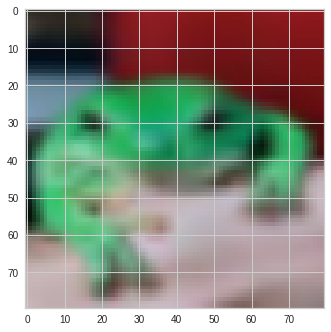

In [ ]:
# image should be a green frog on a brown and red background
plt.imshow(train_data[23433])

In [ ]:
# Save train labels
train_labels_filename = 'train_labels.npz'

if train_labels_filename not in os.listdir():
    save_npy(train_labels_filename, train_labels)
    save_to_drive(drive, folderid, train_labels_filename)

In [ ]:
total_train_images = len(train_data)
total_train_images

50000

## Inception V3

In [ ]:
max_num_samples = 5000 # Colab crashes with too many images
inceptionv3_train_filename = 'inceptionv3_embeddings_train.npz'

inceptionv3_train_embedder = embedding_models.InceptionV3EmbeddingWrapper()

run_data_through_model(
    train_data, 
    inceptionv3_train_embedder, 
    inceptionv3_train_filename,
    drive,
    folderid,
    total_train_images,
    max_num_samples
    )

All images done already.


## Resnet 50

In [ ]:
max_num_samples = 2000
resnet50_train_filename = 'resnet50_embeddings_train.npz'

resnet50_train_embedder = embedding_models.Resnet50EmbeddingWrapper()

run_data_through_model(
    train_data, 
    resnet50_train_embedder, 
    resnet50_train_filename,
    drive,
    folderid,
    total_train_images,
    max_num_samples
    )

All images done already.


## MoCo Resnet 50

In [ ]:
max_num_samples = 1000
moco_resnet50_train_filename = 'moco_resnet50_embeddings_train.npz'

moco_resnet50_train_embedder = embedding_models.MoCoResnet50EmbeddingWrapper()

run_data_through_model(
    train_data, 
    moco_resnet50_train_embedder, 
    moco_resnet50_train_filename,
    drive,
    folderid,
    total_train_images,
    max_num_samples
    )

All images done already.


## PCL Resnet 50

In [ ]:
max_num_samples = 1000
pcl_resnet50_train_filename = 'pcl_resnet50_embeddings_train.npz'

pcl_resnet50_train_embedder = embedding_models.PCLResnet50EmbeddingWrapper()

run_data_through_model(
    train_data, 
    pcl_resnet50_train_embedder, 
    pcl_resnet50_train_filename,
    drive,
    folderid,
    total_train_images,
    max_num_samples
    )

All images done already.


## SwAV Resnet 50

In [ ]:
max_num_samples = 1000
swav_resnet50_train_filename = 'swav_resnet50_embeddings_train.npz'

swav_resnet50_train_embedder = embedding_models.SwAVResnet50EmbeddingWrapper()

run_data_through_model(
    train_data, 
    swav_resnet50_train_embedder, 
    swav_resnet50_train_filename,
    drive,
    folderid,
    total_train_images,
    max_num_samples
    )

Using cache found in /root/.cache/torch/hub/facebookresearch_swav_master


All images done already.


## SimCLR

In [ ]:
max_num_samples = 1000
simclr_train_filename = 'simclr_embeddings_train.npz'

simclr_train_embedder = embedding_models.SimCLREmbeddingWrapper()

run_data_through_model(
    train_data, 
    simclr_train_embedder, 
    simclr_train_filename,
    drive,
    folderid,
    total_train_images,
    max_num_samples
    )

All images done already.


## VGG16

In [ ]:
max_num_samples = 1000
vgg16_train_filename = 'vgg16_embeddings_train.npz'

vgg16_train_embedder = embedding_models.VGG16EmbeddingWrapper()

run_data_through_model(
    train_data, 
    vgg16_train_embedder, 
    vgg16_train_filename,
    drive,
    folderid,
    total_train_images,
    max_num_samples
    )

All images done already.


## CLIP

In [ ]:
max_num_samples = 1000
clip_train_filename = 'clip_embeddings_train.npz'

clip_train_embedder = embedding_models.CLIPEmbeddingWrapper()

run_data_through_model(
    train_data, 
    clip_train_embedder, 
    clip_train_filename,
    drive,
    folderid,
    total_train_images,
    max_num_samples
    )

All images done already.


# Test data split

## Load Data

In [ ]:
dm = DatasetManager()
test_data_generator = dm.load_dataset('cifar10', split="test")

In [ ]:
_data = []
_labels = []
for i, example in enumerate(test_data_generator):
    resized_image = cv2.resize(example['image'], (IMG_WIDTH, IMG_HEIGHT)).astype(np.uint8)
    _data.append(resized_image)
    _labels.append(example['label'])

test_data = np.stack(_data)
test_labels = np.array(_labels)

del _data
del _labels

print('Images shape: ', test_data.shape)
print('Alphabet labels length: ', len(test_labels))


Images shape:  (10000, 80, 80, 3)
Alphabet labels length:  10000


In [ ]:
# Save test labels
test_labels_filename = 'test_labels.npz'

if test_labels_filename not in os.listdir():
    save_npy(test_labels_filename, test_labels)
    save_to_drive(drive, folderid, test_labels_filename)

In [ ]:
total_test_images = len(test_data)
total_test_images

10000

## Inception V3

In [ ]:
max_num_samples = 4000 # Colab crashes with too many images
inceptionv3_test_filename = 'inceptionv3_embeddings_test.npz'

inceptionv3_test_embedder = embedding_models.InceptionV3EmbeddingWrapper()

run_data_through_model(
    test_data, 
    inceptionv3_test_embedder, 
    inceptionv3_test_filename,
    drive,
    folderid,
    total_test_images,
    max_num_samples
    )

All images done already.


## Resnet 50

In [ ]:
max_num_samples = 3000
resnet50_test_filename = 'resnet50_embeddings_test.npz'

resnet50_test_embedder = embedding_models.Resnet50EmbeddingWrapper()

run_data_through_model(
    test_data, 
    resnet50_test_embedder, 
    resnet50_test_filename,
    drive,
    folderid,
    total_test_images,
    max_num_samples
    )

All images done already.


## MoCo Resnet 50

In [ ]:
max_num_samples = 3000
moco_resnet50_test_filename = 'moco_resnet50_embeddings_test.npz'

moco_resnet50_test_embedder = embedding_models.MoCoResnet50EmbeddingWrapper()

run_data_through_model(
    test_data, 
    moco_resnet50_test_embedder, 
    moco_resnet50_test_filename,
    drive,
    folderid,
    total_test_images,
    max_num_samples
    )

All images done already.


## PCL Resnet 50

In [ ]:
max_num_samples = 3000
pcl_resnet50_test_filename = 'pcl_resnet50_embeddings_test.npz'

pcl_resnet50_test_embedder = embedding_models.PCLResnet50EmbeddingWrapper()

run_data_through_model(
    test_data, 
    pcl_resnet50_test_embedder, 
    pcl_resnet50_test_filename,
    drive,
    folderid,
    total_test_images,
    max_num_samples
    )

All images done already.


## SwAV Resnet 50

In [ ]:
max_num_samples = 3000
swav_resnet50_test_filename = 'swav_resnet50_embeddings_test.npz'

swav_resnet50_test_embedder = embedding_models.SwAVResnet50EmbeddingWrapper()

run_data_through_model(
    test_data, 
    swav_resnet50_test_embedder, 
    swav_resnet50_test_filename,
    drive,
    folderid,
    total_test_images,
    max_num_samples
    )

Using cache found in /root/.cache/torch/hub/facebookresearch_swav_master


All images done already.


## SimCLR

In [ ]:
max_num_samples = 3000
simclr_test_filename = 'simclr_embeddings_test.npz'

simclr_test_embedder = embedding_models.SimCLREmbeddingWrapper()

run_data_through_model(
    test_data, 
    simclr_test_embedder, 
    simclr_test_filename,
    drive,
    folderid,
    total_test_images,
    max_num_samples
    )

All images done already.


## VGG16

In [ ]:
max_num_samples = 3000
vgg16_test_filename = 'vgg16_embeddings_test.npz'

vgg16_test_embedder = embedding_models.VGG16EmbeddingWrapper()

run_data_through_model(
    test_data, 
    vgg16_test_embedder, 
    vgg16_test_filename,
    drive,
    folderid,
    total_test_images,
    max_num_samples
    )

All images done already.


## CLIP

In [ ]:
max_num_samples = 1000
clip_test_filename = 'clip_embeddings_test.npz'

clip_test_embedder = embedding_models.CLIPEmbeddingWrapper()

run_data_through_model(
    test_data, 
    clip_test_embedder, 
    clip_test_filename,
    drive,
    folderid,
    total_test_images,
    max_num_samples
    )

Running for image indices 0-1000.


 [elapsed time: 0:00:00] |                                  | (ETA:  --:--:--) 

Embedding images...


 [elapsed time: 0:00:05] |**********************************| (ETA:  00:00:00) 

Data saved to clip_embeddings_test.npz
Uploaded clip_embeddings_test.npz to https://drive.google.com/drive/u/1/folders/1GKPlpMFB9DilMM4201GQAHVokIL94d_N
1000/10000 images done
1000/10000 images done already
Running for image indices 1000-2000.


 [elapsed time: 0:00:00] |***                               | (ETA:   0:00:01) 

Embedding images...


 [elapsed time: 0:00:01] |**********************************| (ETA:  00:00:00) 

Deleting clip_embeddings_test.npz from GDrive
Data saved to clip_embeddings_test.npz
Uploaded clip_embeddings_test.npz to https://drive.google.com/drive/u/1/folders/1GKPlpMFB9DilMM4201GQAHVokIL94d_N
2000/10000 images done
2000/10000 images done already
Running for image indices 2000-3000.


 [elapsed time: 0:00:00] |***                               | (ETA:   0:00:01) 

Embedding images...


 [elapsed time: 0:00:01] |**********************************| (ETA:  00:00:00) 

Deleting clip_embeddings_test.npz from GDrive
Data saved to clip_embeddings_test.npz
Uploaded clip_embeddings_test.npz to https://drive.google.com/drive/u/1/folders/1GKPlpMFB9DilMM4201GQAHVokIL94d_N
3000/10000 images done
3000/10000 images done already
Running for image indices 3000-4000.


 [elapsed time: 0:00:00] |***                               | (ETA:   0:00:01) 

Embedding images...


 [elapsed time: 0:00:01] |**********************************| (ETA:  00:00:00) 

Deleting clip_embeddings_test.npz from GDrive
Data saved to clip_embeddings_test.npz
Uploaded clip_embeddings_test.npz to https://drive.google.com/drive/u/1/folders/1GKPlpMFB9DilMM4201GQAHVokIL94d_N
4000/10000 images done
4000/10000 images done already
Running for image indices 4000-5000.


 [elapsed time: 0:00:00] |***                               | (ETA:   0:00:01) 

Embedding images...


 [elapsed time: 0:00:01] |**********************************| (ETA:  00:00:00) 

Deleting clip_embeddings_test.npz from GDrive
Data saved to clip_embeddings_test.npz
Uploaded clip_embeddings_test.npz to https://drive.google.com/drive/u/1/folders/1GKPlpMFB9DilMM4201GQAHVokIL94d_N
5000/10000 images done
5000/10000 images done already
Running for image indices 5000-6000.


 [elapsed time: 0:00:00] |***                               | (ETA:   0:00:01) 

Embedding images...


 [elapsed time: 0:00:01] |**********************************| (ETA:  00:00:00) 

Deleting clip_embeddings_test.npz from GDrive
Data saved to clip_embeddings_test.npz
Uploaded clip_embeddings_test.npz to https://drive.google.com/drive/u/1/folders/1GKPlpMFB9DilMM4201GQAHVokIL94d_N
6000/10000 images done
6000/10000 images done already
Running for image indices 6000-7000.


 [elapsed time: 0:00:00] |***                               | (ETA:   0:00:01) 

Embedding images...


 [elapsed time: 0:00:01] |**********************************| (ETA:  00:00:00) 

Deleting clip_embeddings_test.npz from GDrive
Data saved to clip_embeddings_test.npz
Uploaded clip_embeddings_test.npz to https://drive.google.com/drive/u/1/folders/1GKPlpMFB9DilMM4201GQAHVokIL94d_N
7000/10000 images done
7000/10000 images done already
Running for image indices 7000-8000.


 [elapsed time: 0:00:00] |***                               | (ETA:   0:00:01) 

Embedding images...


 [elapsed time: 0:00:01] |**********************************| (ETA:  00:00:00) 

Deleting clip_embeddings_test.npz from GDrive
Data saved to clip_embeddings_test.npz
Uploaded clip_embeddings_test.npz to https://drive.google.com/drive/u/1/folders/1GKPlpMFB9DilMM4201GQAHVokIL94d_N
8000/10000 images done
8000/10000 images done already
Running for image indices 8000-9000.


 [elapsed time: 0:00:00] |***                               | (ETA:   0:00:01) 

Embedding images...


 [elapsed time: 0:00:01] |**********************************| (ETA:  00:00:00) 

Deleting clip_embeddings_test.npz from GDrive
Data saved to clip_embeddings_test.npz
Uploaded clip_embeddings_test.npz to https://drive.google.com/drive/u/1/folders/1GKPlpMFB9DilMM4201GQAHVokIL94d_N
9000/10000 images done
9000/10000 images done already
Running for image indices 9000-10000.


 [elapsed time: 0:00:00] |***                               | (ETA:   0:00:01) 

Embedding images...


 [elapsed time: 0:00:01] |**********************************| (ETA:  00:00:00) 

Deleting clip_embeddings_test.npz from GDrive
Data saved to clip_embeddings_test.npz
Uploaded clip_embeddings_test.npz to https://drive.google.com/drive/u/1/folders/1GKPlpMFB9DilMM4201GQAHVokIL94d_N
10000/10000 images done
